# Minimum Distance Between Oil Wells

The idea of this notebook is to show how to find the minimum distance (or reduce the distance) between oil wells. Let's imagine you need to montior wells with a drone for a given remote sensing application, then this becomes a *traveling salesman problem*. mlrose (https://mlrose.readthedocs.io/en/stable/) is the python package used in this example. 

In [246]:
#Neccessary imports
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose
from datetime import datetime
from pyproj import Proj, transform

The data base used for this example was created by automatically downloading production reports from Argentina's Energy Secretary webpage. https://github.com/fzambrun/download_automation_selenium

In [250]:
data = pd.read_csv(r'your_path')

In [251]:
data

Periodo                           Empresa    Cuenca  \
0      Diciembre de 2021  Petrolera Aconcagua Energia S.A.    CUYANA   
1      Diciembre de 2021  Petrolera Aconcagua Energia S.A.    CUYANA   
2      Diciembre de 2021  Petrolera Aconcagua Energia S.A.    CUYANA   
3      Diciembre de 2021  Petrolera Aconcagua Energia S.A.    CUYANA   
4      Diciembre de 2021  Petrolera Aconcagua Energia S.A.    CUYANA   
...                  ...                               ...       ...   
80503  Diciembre de 2021        PETROLERA DEL COMAHUE S.A.  NEUQUINA   
80504  Diciembre de 2021        PETROLERA DEL COMAHUE S.A.  NEUQUINA   
80505  Diciembre de 2021        PETROLERA DEL COMAHUE S.A.  NEUQUINA   
80506  Diciembre de 2021        PETROLERA DEL COMAHUE S.A.  NEUQUINA   
80507  Diciembre de 2021        PETROLERA DEL COMAHUE S.A.  NEUQUINA   

       Provincia               Área         Yacimiento   ID Pozo  \
0        Mendoza  CHAÑARES HERRADOS  CHAÑARES HERRADOS  134330.0   
1        Mendoza  CHAÑARES HERRADOS  CHAÑARES HERRADOS    8392.0   
2        Mendoza  CHAÑARES HERRADOS  CHAÑARES HERRADOS    8393.0   
3        Mendoza  CHAÑARES HERRADOS  CHAÑARES HERRADOS    8394.0   
4        Mendoza  CHAÑARES HERRADOS  CHAÑARES HERRADOS  135326.0   
...          ...                ...                ...       ...   
80503  Rio Negro       GENERAL ROCA       GENERAL ROCA  145625.0   
80504  Rio Negro       GENERAL ROCA       GENERAL ROCA  145623.0   
80505  Rio Negro       GENERAL ROCA       GENERAL ROCA  145626.0   
80506  Rio Negro    PUESTO SURVELIN    PUESTO SURVELIN  144117.0   
80507  Rio Negro    PUESTO SURVELIN    PUESTO SURVELIN   32186.0   

                    Sigla Form.Prod. Cód.Propio  ... Tipo Pozo  Clasificación  \
0         CHE.MD.CH-07(I)       POTR        NaN  ...       PET            NaN   
1          CHE.Md.CH-1001       BARR        NaN  ...       PET            NaN   
2          CHE.Md.CH-1002       BARR        NaN  ...       PET            NaN   
3      CHE.Md.CH-1003(ia)       BARR        NaN  ...        IA            NaN   
4          CHE.Md.CH-1004       RBCO        NaN  ...       PET            NaN   
...                   ...        ...        ...  ...       ...            ...   
80503          YPF.GR.x-5       FIMP        NaN  ...       PET    EXPLORACION   
80504           YPF.G.x-1       FIMP        NaN  ...       PET    EXPLORACION   
80505           YPF.RN.-2       FIMP        NaN  ...       PET    EXPLORACION   
80506           JG.PS.x-1       FIMP        NaN  ...       GAS    EXPLORACION   
80507        YPF.BLO.es-1       FIMP        NaN  ...       GAS    EXPLORACION   

       Sub clasificación  Tipo de Recurso  Sub tipo de Recurso  \
0                    NaN              NaN                  NaN   
1                    NaN              NaN                  NaN   
2                    NaN              NaN                  NaN   
3                    NaN              NaN                  NaN   
4                    NaN              NaN                  NaN   
...                  ...              ...                  ...   
80503        EXPLORACION     CONVENCIONAL                  NaN   
80504        EXPLORACION     CONVENCIONAL                  NaN   
80505        EXPLORACION     CONVENCIONAL                  NaN   
80506        EXPLORACION     CONVENCIONAL                  NaN   
80507        EXPLORACION     CONVENCIONAL                  NaN   

                                        Observaciones    Latitud   Longitud  \
0                                                 NaN -33.382300 -68.993700   
1                                                 NaN -33.343264 -68.977378   
2                                                 NaN -33.344875 -69.000906   
3                                                 NaN -33.332189 -68.974823   
4                                                 NaN -33.342900 -68.996000   
...                                               ...        ...        ...   
80503  Cargado a

Let's get the names of some oilfieds that have a few oil wells to test the algorithm. As in any TSP problem, as **n** increases the solution becomes more complex. Keep in mind that number of total combinations is **n!**

In [252]:
df= data['Yacimiento'].value_counts()
mask_10 = df==10
print(df[mask_10])
print(len(df[mask_10]))

LOMA MONTOSA              10
LAS BASES                 10
CERRO FORTUNOSO SUR       10
CHANGO NORTE-PORCELANA    10
EL CERRITO                10
PUNTA LOYOLA              10
SUR RIO CHICO - ASGN      10
PUELEN                    10
RINCONADA NORTE           10
EL ALPATACO               10
CERRO BANDERA NORTE       10
CERRO GUADAL              10
CERRO MOLLAR NORTE        10
AGUA DE LA CERDA NORTE    10
PUESTO SILVA OESTE        10
RISCO ALTO                10
ATUEL NORTE               10
CAÑADON PILAR             10
Name: Yacimiento, dtype: int64
18


Coordinates will be reporjected from EPSG 4326 (spheric) to EPSG3857 (planar) so that results can be plotted.

In [253]:
lat_epsg3857, lon_epsg3857 = transform("EPSG:4326", "EPSG:3857",list(data['Latitud']),list(data['Longitud']))
data['lat_epsg3857'] = lat_epsg3857
data['lon_epsg3857'] = lon_epsg3857

Picking one random name from the list above showing well locatios in red

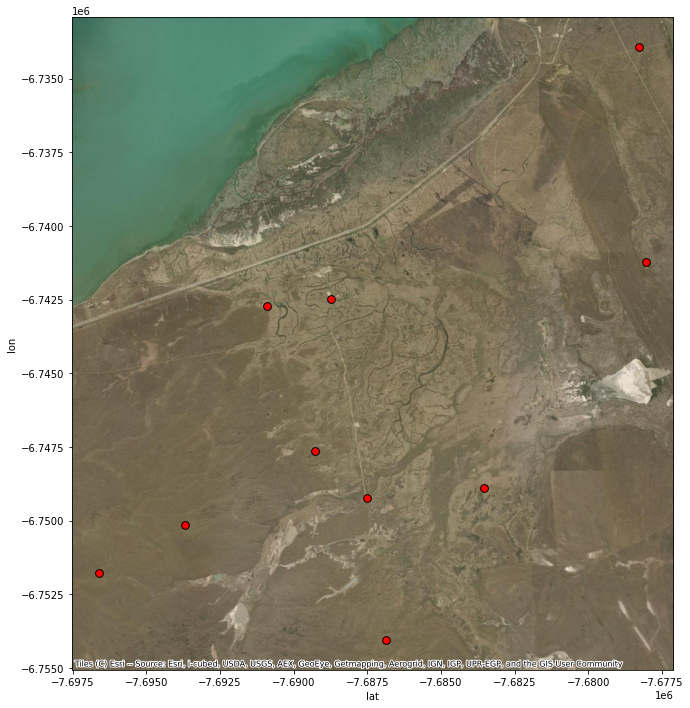

In [254]:
#filtro por Yacimiento
mask_Y= data['Yacimiento']== 'PUNTA LOYOLA'
df_Y = data[mask_Y]

x = df_Y.lat_epsg3857
y = df_Y.lon_epsg3857

fig2, ax2 = plt.subplots(figsize=(12,12))
ax2.set_xlabel('lat')
ax2.set_ylabel('lon')
#plt.grid()
plt.scatter(x,y, color='red', edgecolor='black', s=60)


ctx.add_basemap(ax2, source=ctx.providers.Esri.WorldImagery)


Let's define a function that will address this TSP problem. The final solution is determined by using a genetic algorithm so there is no guarantee that the result is the optimum solution. But as the number of max iterations increases the function will test more combiantions looking for a shorter alternative hence it's expected that the calculated total distance will decrease. Setting a high number of iterations has it's downside, which is that fuctions will take longer to run. 

In [255]:
def best_fit(oilfield,iters,mutation):
    
    mask_Y= data['Yacimiento']== oilfield
    df_Y = data[mask_Y]
    
    x = df_Y.lat_epsg3857
    y = df_Y.lon_epsg3857
    
    points = len(y)
    
    coords_list = tuple(map(list, zip(x, y)))
    fitness_coords = mlrose.TravellingSales(coords = coords_list)
    problem_fit = mlrose.TSPOpt(length = points, fitness_fn = fitness_coords, maximize=False)

    startTime = datetime.now()

    best_state, best_fitness = mlrose.genetic_alg(problem_fit,mutation_prob = mutation, max_attempts = iters , random_state = 2)

    t = (datetime.now() - startTime).total_seconds()
    
    return oilfield, iters, mutation, best_state , best_fitness , t

We will test this new function with a fixed mutation probablitly but with different values of the paraemter max_iters and se the total distance and time it takes to get to that result

In [259]:
list_iters = [1,10,50,100,500,1000,5000,10000]

list_solutions = []

for i in list_iters:
    list_solutions.append(best_fit('PUNTA LOYOLA',i,0.2))

df_solution = pd.DataFrame(list_solutions)
columns = ['oilfield', 'iters', 'mutation', 'best_state' , 'best_fitness' , 't']
df_solution.columns = columns

df_solution

oilfield  iters  mutation                      best_state  \
0  PUNTA LOYOLA      1       0.2  [6, 0, 2, 1, 5, 4, 3, 8, 9, 7]   
1  PUNTA LOYOLA     10       0.2  [7, 6, 0, 9, 1, 4, 5, 3, 8, 2]   
2  PUNTA LOYOLA     50       0.2  [7, 6, 0, 9, 1, 4, 5, 3, 8, 2]   
3  PUNTA LOYOLA    100       0.2  [7, 2, 4, 5, 3, 1, 8, 9, 0, 6]   
4  PUNTA LOYOLA    500       0.2  [2, 7, 6, 0, 9, 3, 4, 5, 8, 1]   
5  PUNTA LOYOLA   1000       0.2  [2, 7, 6, 0, 9, 3, 4, 5, 8, 1]   
6  PUNTA LOYOLA   5000       0.2  [6, 0, 9, 8, 3, 4, 5, 1, 2, 7]   
7  PUNTA LOYOLA  10000       0.2  [6, 0, 9, 8, 3, 4, 5, 1, 2, 7]   

   best_fitness           t  
0  74398.925640    0.353995  
1  70135.213140    1.753887  
2  70135.213140    4.370347  
3  67577.923243   13.603054  
4  65747.790398   63.679682  
5  65747.790398   96.076147  
6  64828.537239  466.166251  
7  64828.537239  758.274870

By ploting the distance calculated (best_fitness) vs iterations we can see the relation. After certain number of iterations the distance vary very little and, of course, the more iterations the more time will the code take to run.

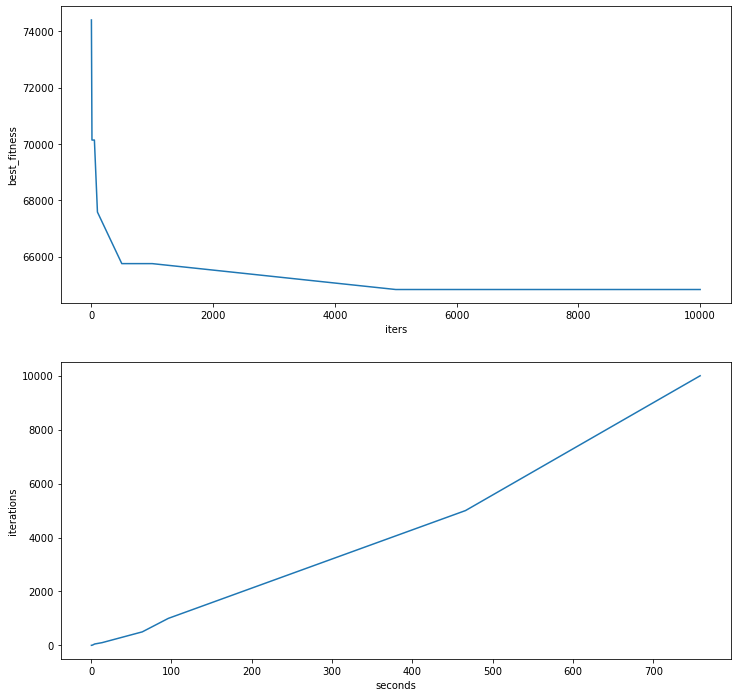

In [260]:
fig, axs = plt.subplots(2,1, figsize=(12,12))
axs[0].plot(df_solution['iters'], df_solution['best_fitness'])
axs[0].set_xlabel('iters')
axs[0].set_ylabel('best_fitness')
axs[1].plot(df_solution['t'], df_solution['iters'])
axs[1].set_xlabel('seconds')
axs[1].set_ylabel('iterations')
plt.show()

In [261]:
def plot_solution(solution):
    
    
    mask_Y= data['Yacimiento']== solution[0]
    df_Y = data[mask_Y]
    
    x = df_Y.lat_epsg3857
    y = df_Y.lon_epsg3857
    
    points = len(y)
    
    coords_list = tuple(map(list, zip(x, y)))
    fitness_coords = mlrose.TravellingSales(coords = coords_list)
  
    best_state_coords=[]
    for i in solution[3]:
        c = coords_list[i]
        best_state_coords.append(c)

    x_1, y_1 = zip(*best_state_coords)

    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_title('Pozos')
    ax.set_xlabel('lat')
    ax.set_ylabel('lon')
    plt.plot(x_1,y_1, linestyle= 'dotted', color='black')
    plt.scatter(x_1,y_1, color='red', edgecolor='black')

    ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)
    

Below, the evolution of the route suggested by the optimization algorithm its shown.

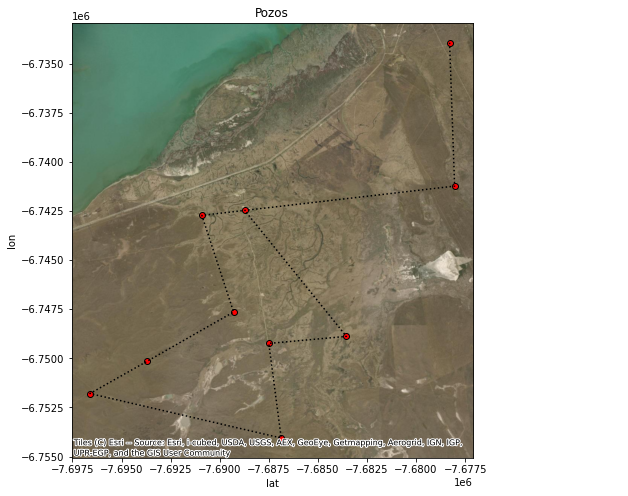

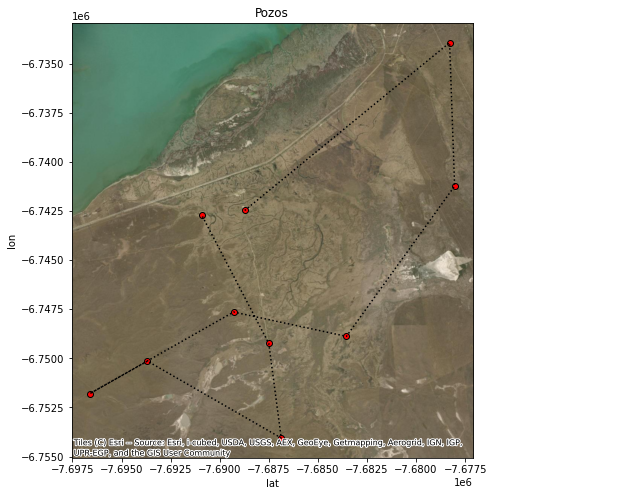

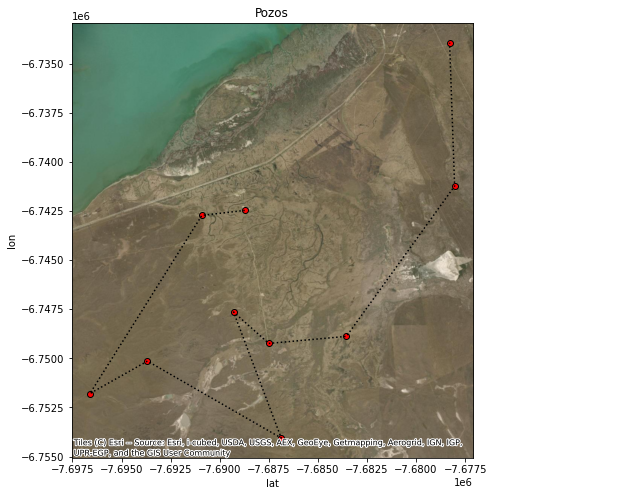

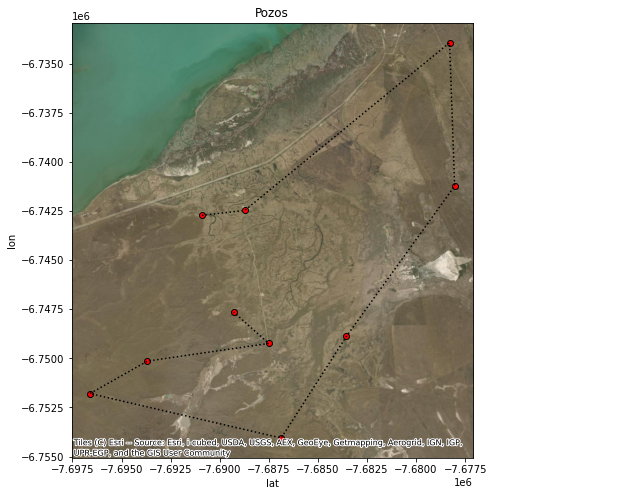

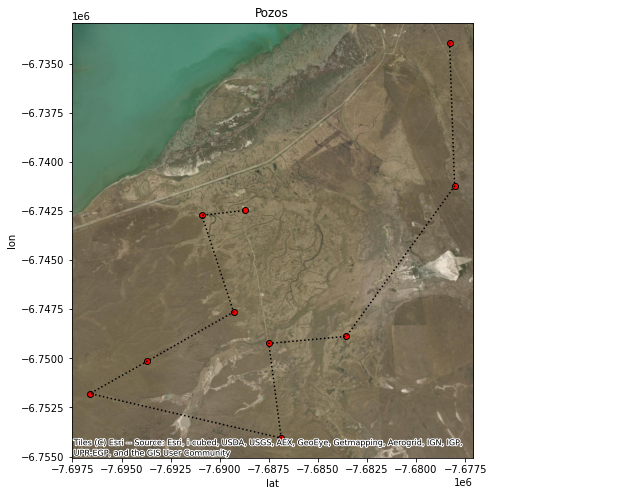

In [262]:
for i in [0,1,3,4,6]:
    plot_solution(df_solution.loc[i])

We will do the same for the first 10 oilfields filtered previously (those with 10 wells) and try to determine which would be the best value of max_iters to use in this case. We will do si by compareing how much does the calculated distance reduces measured against a first random route.

In [269]:
for oilfield in df[mask_10].head(10).index:
    for i in list_iters:
        list_solutions.append(best_fit(oilfield,i,0.2))

df_solution_2 = pd.DataFrame(list_solutions)
columns = ['oilfield', 'iters', 'mutation', 'best_state' , 'best_fitness' , 't']
df_solution_2.columns = columns

def f(row):
    oilfield_name = row['oilfield']
    value = row['best_fitness']/df_solution_2[df_solution_2['oilfield']==oilfield_name]['best_fitness'].max()
    return value

reduction = df_solution_2.apply(f,axis=1)

df_solution_2['reduction'] = reduction

df_solution_2

oilfield  iters  mutation                      best_state  \
0   PUNTA LOYOLA      1       0.2  [6, 0, 2, 1, 5, 4, 3, 8, 9, 7]   
1   PUNTA LOYOLA     10       0.2  [7, 6, 0, 9, 1, 4, 5, 3, 8, 2]   
2   PUNTA LOYOLA     50       0.2  [7, 6, 0, 9, 1, 4, 5, 3, 8, 2]   
3   PUNTA LOYOLA    100       0.2  [7, 2, 4, 5, 3, 1, 8, 9, 0, 6]   
4   PUNTA LOYOLA    500       0.2  [2, 7, 6, 0, 9, 3, 4, 5, 8, 1]   
..           ...    ...       ...                             ...   
83   EL ALPATACO    100       0.2  [7, 3, 4, 5, 2, 8, 9, 6, 1, 0]   
84   EL ALPATACO    500       0.2  [7, 3, 4, 5, 2, 8, 9, 6, 1, 0]   
85   EL ALPATACO   1000       0.2  [5, 3, 4, 7, 0, 1, 6, 9, 8, 2]   
86   EL ALPATACO   5000       0.2  [6, 1, 0, 7, 4, 3, 5, 2, 8, 9]   
87   EL ALPATACO  10000       0.2  [6, 1, 0, 7, 4, 3, 5, 2, 8, 9]   

    best_fitness           t  reduction  
0   74398.925640    0.353995   1.000000  
1   70135.213140    1.753887   0.942691  
2   70135.213140    4.370347   0.942691  
3   67577.923243   13.603054   0.908319  
4   65747.790398   63.679682   0.883720  
..           ...         ...        ...  
83   6869.206281   10.419746   0.882083  
84   6869.206281   33.863257   0.882083  
85   6830.928815  103.511832   0.877168  
86   6830.928815  455.689155   0.877168  
87   6830.928815  758.405217   0.877168  

[88 rows x 7 columns]

<AxesSubplot:xlabel='iters', ylabel='reduction'>

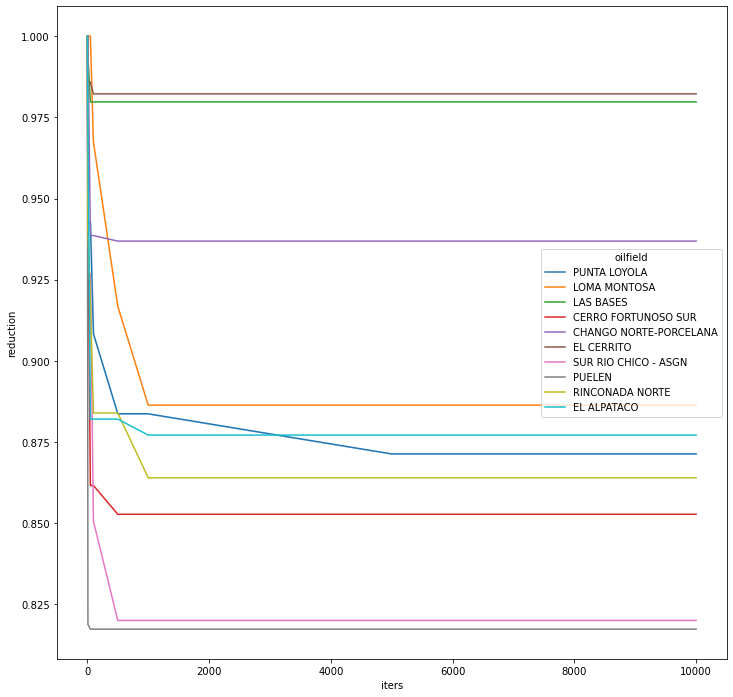

In [272]:
import seaborn as sns
fig, axs = plt.subplots(figsize=(12,12))
sns.lineplot(data=df_solution_2, x="iters", y="reduction", hue='oilfield')

For a problem with 10 ponits, it seems that after 2000 iteraions the there is no considrable improvement in the result. We will set max_iters to 2000 to apply the function to the remaining 8 oilfields in the list and plot the solution for them.

In [288]:
solutions_2000 = []

i=2000

for oilfield in df[mask_10].tail(8).index:
        solutions_2000.append(best_fit(oilfield,i,0.2))

df_solutions_2000 = pd.DataFrame(solutions_2000, columns=columns)
df_solutions_2000

oilfield  iters  mutation                      best_state  \
0     CERRO BANDERA NORTE   2000       0.2  [0, 4, 5, 1, 3, 9, 6, 8, 7, 2]   
1            CERRO GUADAL   2000       0.2  [0, 1, 6, 8, 9, 2, 3, 4, 5, 7]   
2      CERRO MOLLAR NORTE   2000       0.2  [6, 4, 3, 5, 2, 7, 0, 1, 9, 8]   
3  AGUA DE LA CERDA NORTE   2000       0.2  [9, 6, 5, 0, 7, 3, 2, 1, 4, 8]   
4      PUESTO SILVA OESTE   2000       0.2  [5, 4, 7, 6, 0, 9, 8, 2, 1, 3]   
5              RISCO ALTO   2000       0.2  [0, 9, 4, 3, 2, 6, 5, 7, 8, 1]   
6             ATUEL NORTE   2000       0.2  [7, 3, 6, 2, 4, 1, 0, 5, 9, 8]   
7           CAÑADON PILAR   2000       0.2  [9, 4, 0, 2, 1, 8, 6, 7, 3, 5]   

   best_fitness           t  
0  19297.180984  218.001133  
1  67883.588106  333.962063  
2   6592.385836  170.129325  
3   7028.292036  175.779627  
4  15559.551190  135.319989  
5  11220.563972  209.204163  
6  15871.644620  218.004505  
7  34866.774534  133.283441

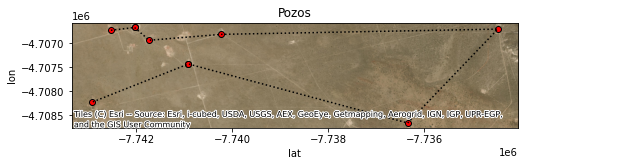

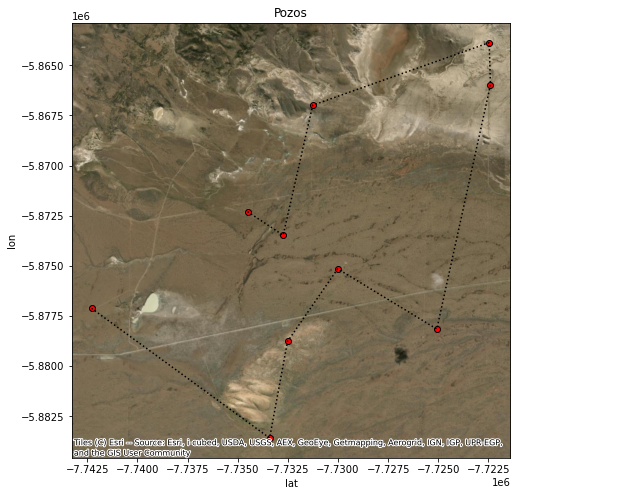

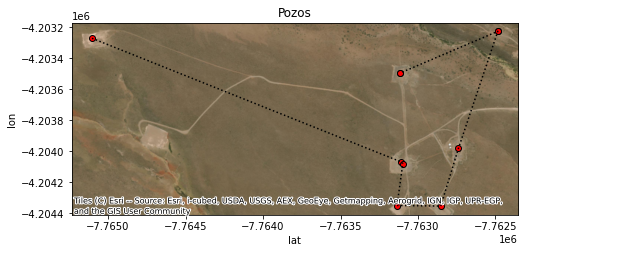

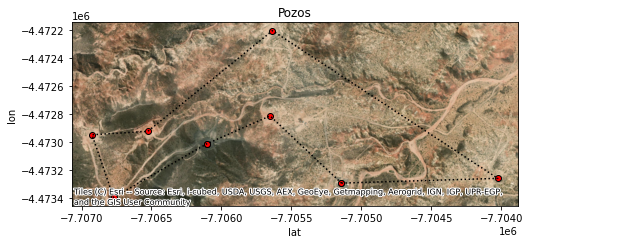

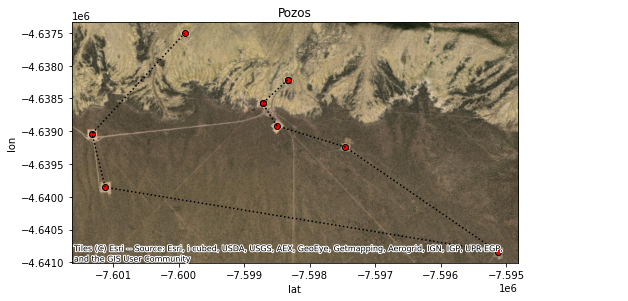

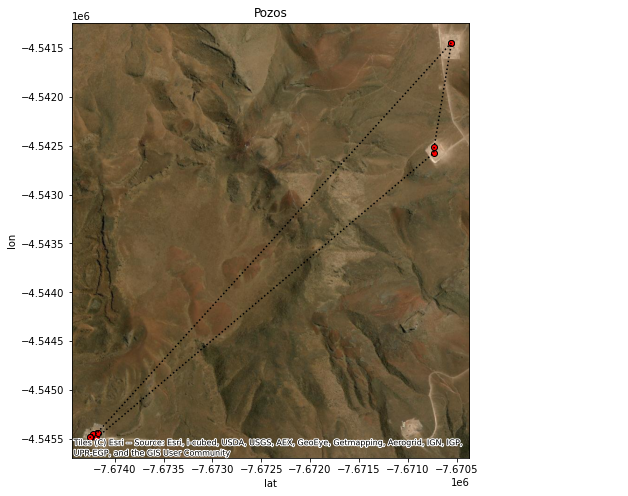

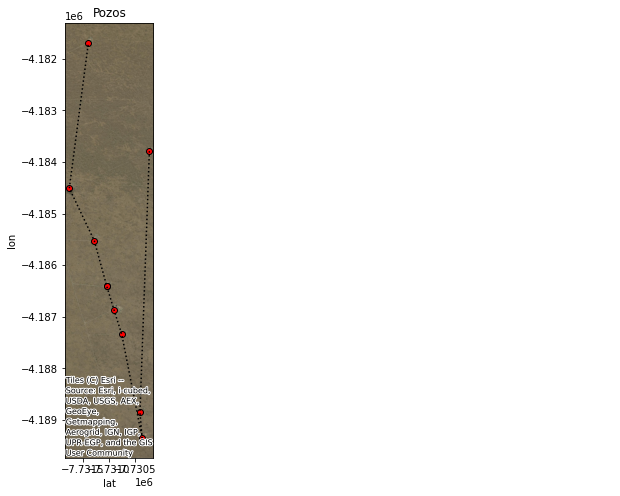

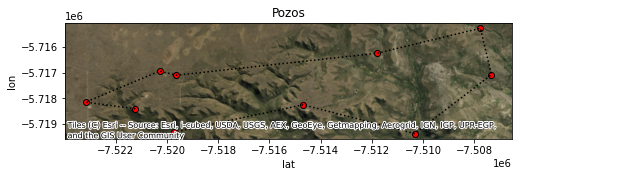

In [292]:
for i in df_solutions_2000.index:
    plot_solution(df_solutions_2000.loc[i])